# **RECORDLINKAGE  TOOL**

In [1]:
import pandas as pd

### Required imports

In [5]:
import comet_ml
import recordlinkage
import pandas as pd
import numpy as np
import shapash
import mlxtend
import pickle
import random

import warnings; warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from shapash.explainer.smart_explainer import SmartExplainer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from codecarbon import EmissionsTracker
from lightgbm import LGBMClassifier
from recordlinkage import datasets
from comet_ml import Experiment
from PIL import Image


### Loading datasets 

In [6]:
first_febrl_dataset, second_febrl_dataset = datasets.load_febrl4(return_links=False)

In [7]:
indexes_frst_febrl_dataset = sorted(first_febrl_dataset.index)
indexes_scd_febrl_dataset = sorted(second_febrl_dataset.index)
tuples_true_links = list(zip(indexes_frst_febrl_dataset, indexes_scd_febrl_dataset))
true_links = pd.MultiIndex.from_tuples(tuples_true_links, names=('org_data', 'dpl_data'))

In [8]:
display(first_febrl_dataset)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1070-org,michaela,neumann,8,stanley street,miami,winston hills,4223,nsw,19151111,5304218
rec-1016-org,courtney,painter,12,pinkerton circuit,bega flats,richlands,4560,vic,19161214,4066625
rec-4405-org,charles,green,38,salkauskas crescent,kela,dapto,4566,nsw,19480930,4365168
rec-1288-org,vanessa,parr,905,macquoid place,broadbridge manor,south grafton,2135,sa,19951119,9239102
rec-3585-org,mikayla,malloney,37,randwick road,avalind,hoppers crossing,4552,vic,19860208,7207688
...,...,...,...,...,...,...,...,...,...,...
rec-2153-org,annabel,grierson,97,mclachlan crescent,lantana lodge,broome,2480,nsw,19840224,7676186
rec-1604-org,sienna,musolino,22,smeaton circuit,pangani,mckinnon,2700,nsw,19890525,4971506
rec-1003-org,bradley,matthews,2,jondol place,horseshoe ck,jacobs well,7018,sa,19481122,8927667


## **PREPROCESSING**

Recordlinkage propose un étape de préprocessing. Nous ne l'utilisons pas ici car les données utilisées sont déjà pré processées. 

## **INDEXATION**

L'indexation n'est faisable que sur **un** ou **deux** jeu de données. 4 méthodes d'indexations sont proposées par l'outil:
- Full : renvoie toutes les combinaisons de paires possibles
- Block : renvoie toutes les lignes ayant des valeurs égales sur une ou plusieurs des colonnes données en entrée 
- SortedNeighbourhood : renvoie les paires ayant des valeurs similaires sur une ou plusieurs des colonnes données en entrée et celles dans leur voisinnage
- Random : renvoie des paires crées aléatoirement

Ici, nous testons les méthodes **block** et **SortedNeighbourhood** en utilisant les colonnes 'given_name', 'address_1' et 'date_of_birth'. 

### **1. Méthode de blocage**

In [9]:
def block_indexing(blocking_key: list):
    indexer = recordlinkage.Index()
    for column in blocking_key:
        indexer.block(on=column)
        pairs_to_comp = indexer.index(first_febrl_dataset, second_febrl_dataset)
        real_link_found = pairs_to_comp & true_links
        print("Nombre de paires sélectionnées: {}".format(len(pairs_to_comp)))
        print("Pourcentage de vraies paires selctionnées: {}%. \n".format(len(real_link_found)/len(true_links)*100))
        
    return pairs_to_comp

Pour évaluer les résultats de la méthode d'indexation utilisée, nous regardons deux élements:
- le pourcentage de paires dupliquées detectées
- la performance de la méthode en fonction du nombre de clé de blockage utilisée


In [10]:
pairs_to_comp_block = block_indexing(['given_name', 'address_1', 'date_of_birth'])

Nombre de paires sélectionnées: 77249
Pourcentage de vraies paires selctionnées: 65.74%. 

Nombre de paires sélectionnées: 85758
Pourcentage de vraies paires selctionnées: 87.42%. 

Nombre de paires sélectionnées: 86959
Pourcentage de vraies paires selctionnées: 98.72%. 



L'étape d'indexation est cruciale. **Plus on donne d'informations (précises) en entrée, meilleure est la précision selection de paires de candidats à comparer.** 

#### **Ressemblance des paires selectionnées**

Le processus de recherche des clés peut être effectuée de manière itérative, en examinant manuellement la sortie du blocage et en réglant la clé jusqu'à ce que la précision requise soit atteinte.

In [11]:
def selected_pairs_values(list_tuple:list):
    selected_pairs_values_df = pd.DataFrame(columns=first_febrl_dataset.columns)
    for tpl in list_tuple:
        first_candidate = first_febrl_dataset.iloc[first_febrl_dataset.index.isin([tpl[0]])]
        second_candidate = second_febrl_dataset.iloc[second_febrl_dataset.index.isin([tpl[1]])]
        concat_df = pd.concat([first_candidate, second_candidate])
        #candidates_df = candidates_df.style.applymap(lambda x: 'background-color: yellow' if True else '')
        
        selected_pairs_values_df = pd.concat([selected_pairs_values_df, concat_df])
    return selected_pairs_values_df 

### **2. Méthode du SortedNeighborhood**

Dans le cas ou les données sont susceptible de contenir des erreurs de typographies, utiliser la méthode SortedNeighborhood peut ajouter une certaine flexibilité pour les fautes d'orthographe mineures. 

In [12]:
def sorted_neighbourhood_indexing(blocking_key: list):
    for column in blocking_key:
        indexer = recordlinkage.SortedNeighbourhoodIndex(column)
        pairs_to_comp = indexer.index(first_febrl_dataset, second_febrl_dataset)
        real_link_found = pairs_to_comp & true_links
        print("Nombre de paires sélectionnées: {}".format(len(pairs_to_comp)))
        print("Pourcentage de vraies paires selctionnées: {}%.\n".format(len(real_link_found)/len(true_links)*100))
        
    return pairs_to_comp

In [13]:
pairs_to_comp_sn = sorted_neighbourhood_indexing(['given_name', 'address_1', 'date_of_birth', 'soc_sec_id'])

Nombre de paires sélectionnées: 96573
Pourcentage de vraies paires selctionnées: 71.26%.

Nombre de paires sélectionnées: 21383
Pourcentage de vraies paires selctionnées: 83.86%.

Nombre de paires sélectionnées: 14770
Pourcentage de vraies paires selctionnées: 89.48%.

Nombre de paires sélectionnées: 13901
Pourcentage de vraies paires selctionnées: 94.48%.



## **COMPARAISON**

La méthode suivante consiste à comparer les paires en utilisant *Compare*.
Nous pouvons définir plusieurs options pour la façon dont nous voulons comparer les colonnes de données.

In [14]:
compare = recordlinkage.Compare()

# initialise similarity measurement algorithms
compare.string('given_name', 'given_name', method='jarowinkler')
compare.string('surname', 'surname', method='jarowinkler')
compare.string('address_1', 'address_1', method='levenshtein')
compare.exact('soc_sec_id', 'soc_sec_id')

# the method .compute() returns the DataFrame with the feature vectors.
comp_scores = compare.compute(pairs_to_comp_block, first_febrl_dataset, second_febrl_dataset)

In [15]:
comp_scores['tupled_index'] = comp_scores.index.tolist()
comp_scores['label'] = comp_scores['tupled_index'].apply(lambda x: 1 if x in true_links else 0)
comp_scores.columns = ['given_name_score', 'surname_score', 'address_1_score', 'soc_sec_id_score', 'tupled_index', 'label']

In [16]:
comp_scores

given_name_score  surname_score  address_1_score  \
rec_id_1    rec_id_2                                                           
rec-0-org   rec-0-dup-0             1.000000       1.000000         1.000000   
            rec-1230-dup-0          0.595238       0.407407         1.000000   
            rec-2323-dup-0          1.000000       0.000000         0.235294   
            rec-254-dup-0           0.000000       0.500000         1.000000   
            rec-3625-dup-0          0.714286       0.000000         1.000000   
...                                      ...            ...              ...   
rec-999-org rec-4961-dup-0          1.000000       0.458333         0.000000   
            rec-56-dup-0            1.000000       0.453704         0.133333   
            rec-675-dup-0           1.000000       0.000000         0.133333   
            rec-91-dup-0            1.000000       0.611111         0.466667   
            rec-999-dup-0           1.000000       1.000000         1.000000   

                            soc_sec_id_score                   tupled_index  \
rec_id_1    rec_id_2                                                          
rec-0-org   rec-0-dup-0                    1       (rec-0-org, rec-0-dup-0)   
            rec-1230-dup-0                 0    (rec-0-org, rec-1230-dup-0)   
            rec-2323-dup-0                 0    (rec-0-org, rec-2323-dup-0)   
            rec-254-dup-0                  0     (rec-0-org, rec-254-dup-0)   
            rec-3625-dup-0                 0    (rec-0-org, rec-3625-dup-0)   
...                                      ...                            ...   
rec-999-org rec-4961-dup-0                 0  (rec-999-org, rec-4961-dup-0)   
            rec-56-dup-0                   0    (rec-999-org, rec-56-dup-0)   
            rec-675-dup-0                  0   (rec-999-org, rec-675-dup-0)   
            rec-91-dup-0                   0    (rec-999-org, rec-91-dup-0)   
            rec-999-dup-0                  1   (rec-999-org, rec-999-dup-0)   

                            label  
rec_id_1    rec_id_2               
rec-0-org   rec-0-dup-0         1  
            rec-1230-dup-0      0  
            rec-2323-dup-0      0  
            rec-254-dup-0       0  
            rec-3625-dup-0      0  
...                           ...  
rec-999-org rec-4961-dup-0      0  
            rec-56-dup-0        0  
            rec-675-dup-0       0  
            rec-91-dup-0        0  
            rec-999-dup-0       1  

[86959 rows x 6 columns]

### **CLASSIFICATION & CODE CARBON**

Les vecteurs de scores de similarités sont donnés en entrée au classifieur (supervisé ou non supervisé). 

In [17]:
train, test = train_test_split(comp_scores, test_size=0.25)
X_train = train[['given_name_score', 'surname_score', 'address_1_score', 'soc_sec_id_score']]
X_test = test[['given_name_score', 'surname_score', 'address_1_score', 'soc_sec_id_score']]
y_train, y_test = train['label'], test['label']

In [18]:
tracker = EmissionsTracker(project_name="tdf_innovation")
tracker.start()

classifier = LGBMClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

tracker.stop()

INFO:apscheduler.scheduler:Adding job tentatively -- it will be properly scheduled when the scheduler starts
INFO:apscheduler.scheduler:Added job "BaseEmissionsTracker._measure_power" to job store "default"
INFO:apscheduler.scheduler:Scheduler started
INFO:apscheduler.scheduler:Scheduler has been shut down


2.0890598668593197e-07

In [55]:
code_carbon_res = Image.open('illustration/codecarbon_vis.png');

FileNotFoundError: [Errno 2] No such file or directory: 'illustration/codecarbon_vis.png'

INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "GET /_dash-layout HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 15:52:28] "POST /_dash-updat

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/

ERROR:shapash.webapp.smart_app:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/m

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/

ERROR:shapash.webapp.smart_app:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/m

In [ ]:
code_carbon_res

## EVALUATION 

Pour évaluer le modèle de classification, nous utilisons les méthodes d'évaluation de performance habituelles.

In [20]:
def evaluation(Y_test, predictions):
    recall = recall_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)
    accuracy = accuracy_score(Y_test, predictions)
    
    print("Rappel: {}".format(recall))
    print("Precision: {}".format(precision))
    print("Accuracy: {}".format(accuracy))
    print("0 : match \n1: non match")
    plot_confusion_matrix(confusion_matrix(Y_test, predictions))
    
    return recall, precision, accuracy

Rappel: 0.9845916795069337
Precision: 0.9961028838659393
Accuracy: 0.9988500459981601
0 : match 
1: non match


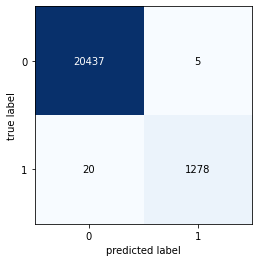

In [21]:
recall, precision, accuracy = evaluation(y_test, predictions)

**Visualisation des erreurs: faux positifs et faux négatifs**

In [22]:
def select_candidates_from_false_negatif_prediction():
    false_negatif_df = pd.DataFrame(columns = first_febrl_dataset.columns)
    predicted_non_match = list(set(test.index) - set(predictions))
    # format change
    predicted_non_match = pd.MultiIndex.from_tuples(predicted_non_match, names=('org', 'dup'))
    false_negatif = predicted_non_match & true_links 
        
    for tpl in false_negatif: 
        first_candidate = first_febrl_dataset.iloc[first_febrl_dataset.index.isin([tpl[0]])]
        second_candidate = second_febrl_dataset.iloc[second_febrl_dataset.index.isin([tpl[1]])]
        false_negatif_df = pd.concat([false_negatif_df, first_candidate, second_candidate])
    return false_negatif_df 

def select_candidates_from_false_positif_prediction():
    false_positif_df = pd.DataFrame(columns = first_febrl_dataset.columns)
    false_positif = list(set(predictions) - set(true_links))
    
    for tpl in false_positif: 
        first_candidate = first_febrl_dataset.iloc[first_febrl_dataset.index.isin([tpl[0]])]
        second_candidate = second_febrl_dataset.iloc[second_febrl_dataset.index.isin([tpl[1]])]
        false_positif_df = pd.concat([false_positif_df, first_candidate, second_candidate])
    return false_positif_df 

## **HUMAN REVIEW**

La dernière étape est la revue humaine. Pour l'accompagner, nous utilisons l'outil shapash, qui est un outil de visualisation.

In [23]:
features = {
     'given_name_score': 'given_name_score',
     'surname_score': 'surname_score',
     'address_1_score': 'address_1_score',
     'soc_sec_id_score': 'soc_sec_id_score'
}
interpretable_train = train[['given_name_score', 'surname_score', 'address_1_score', 'soc_sec_id_score']]

In [24]:
xpl = SmartExplainer(features_dict=features) # optional parameter
xpl.compile(
    x=X_test,
    model=classifier,
    y_pred= y_test
)

Backend: Shap TreeExplainer


In [22]:
feature_importances = Image.open('features_importances.png')
feature_contribution = Image.open('feature_contribution.png');

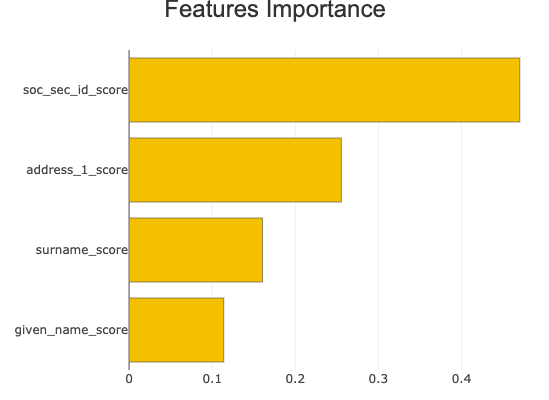

In [23]:
feature_importances

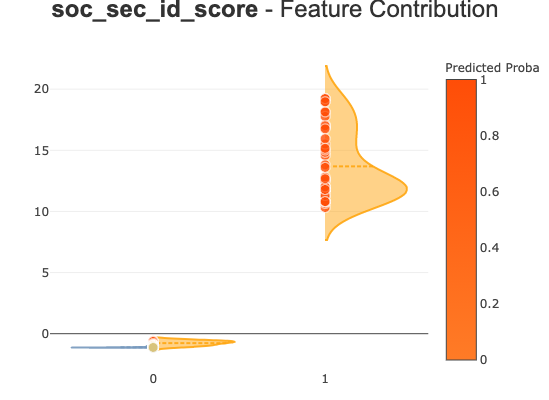

In [24]:
feature_contribution

In [34]:
app = xpl.run_app(title_story='Dupliacte Matches')

INFO:root:Your Shapash application run on http://AMAC02DH1CJML85:8050/


Dash is running on http://0.0.0.0:8050/



INFO:root:Use the method .kill() to down your app.
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 09:17:02] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 09:17:02] "GET /assets/material-icons.css?m=1616599895.3155472 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 09:17:02] "GET /assets/style.css?m=1616599895.3188891 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 09:17:02] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_8_3m1616685724.7.2.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 09:17:02] "GET /_dash-component-suites/dash_renderer/react@16.v1_8_3m1616685724.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 09:17:02] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_8_3m1616685724.14.0.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [01/Apr/2021 09:17:02] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_8_3m1616685724.8.7.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/

ERROR:shapash.webapp.smart_app:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/m

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/

ERROR:shapash.webapp.smart_app:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/Users/marylin.pemodjo/.pyenv/versions/tdf_innovation_venv/lib/python3.7/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/m

In [26]:
app.kill()

   Use a production WSGI server instead.


## **META DONNÉES**

In [27]:
interpretability_meta_data_model = {
    'model_version' : 'test',
    'features': features,
    'interpretable_model_train' : X_test,
    'model_to_interprete' : classifier,
    'prediction_to_mimic' : y_test
}

In [28]:
interpretability_meta_data_model

{'model_version': 'test',
 'features': {'given_name_score': 'given_name_score',
  'surname_score': 'surname_score',
  'address_1_score': 'address_1_score',
  'soc_sec_id_score': 'soc_sec_id_score'},
 'interpretable_model_train':                              given_name_score  surname_score  address_1_score  \
 rec_id_1     rec_id_2                                                           
 rec-4285-org rec-1809-dup-0               1.0       0.600000         0.500000   
 rec-762-org  rec-4535-dup-0               0.0       0.500000         1.000000   
 rec-504-org  rec-1475-dup-0               1.0       0.436508         0.500000   
 rec-1191-org rec-856-dup-0                1.0       0.000000         0.250000   
 rec-2135-org rec-4721-dup-0               1.0       0.600000         0.105263   
 ...                                       ...            ...              ...   
 rec-4285-org rec-3316-dup-0               1.0       0.642857         0.333333   
 rec-2578-org rec-3067-dup-0      

In [29]:
deduplication_pipeline_metadonnees = {
    'first_dataset_shape' : first_febrl_dataset.shape,
    'second_dataset_shape' : second_febrl_dataset.shape,
    'indexing_method' : 'block',
    'columns_used_for_indexing' : ['given_name', 'address_1', 'date_of_birth'],
    'columns_compared' : ['given_name', 'surname', 'address_1', 'soc_sec_id'],
    'string_method_used_for_comp' : {'given_name':'jarowinckler', 'surname':'jarowinckler','address_1':'levenshtein'},
    'model_classification' : 'LGBMClassifier',
    'train_size' : train.shape[0],
    'test_size' : test.shape[0],
    'recall_score' : recall,
    'precision' : precision,
    'accuracy' : accuracy,
}

In [30]:
def add_emissions_meta_donnée(file_path):
    emissions_infos = pd.read_csv(file_path).iloc[-1:, :]
    for column in emissions_infos[['duration', 'emissions', 'energy_consumed']]:
        deduplication_pipeline_metadonnees[column] = emissions_infos[column]
        
    return deduplication_pipeline_metadonnees

In [31]:
add_emissions_meta_donnée("emissions.csv")

{'first_dataset_shape': (5000, 10),
 'second_dataset_shape': (5000, 10),
 'indexing_method': 'block',
 'columns_used_for_indexing': ['given_name', 'address_1', 'date_of_birth'],
 'columns_compared': ['given_name', 'surname', 'address_1', 'soc_sec_id'],
 'string_method_used_for_comp': {'given_name': 'jarowinckler',
  'surname': 'jarowinckler',
  'address_1': 'levenshtein'},
 'model_classification': 'LGBMClassifier',
 'train_size': 65219,
 'test_size': 21740,
 'recall_score': 0.986863711001642,
 'precision': 0.9950331125827815,
 'accuracy': 0.9989880404783809,
 'duration': 12    4.680032
 Name: duration, dtype: float64,
 'emissions': 12    6.013967e-08
 Name: emissions, dtype: float64,
 'energy_consumed': 12    1.416438e-07
 Name: energy_consumed, dtype: float64}